In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split

In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip ./

In [4]:
!unzip cats_vs_dogs_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/dogs/dog4779.jpg  
  inflating: dataset/train/dogs/dog4443.jpg  
  inflating: dataset/train/dogs/dog858.jpg  
  inflating: dataset/train/dogs/dog1709.jpg  
  inflating: dataset/train/dogs/dog5839.jpg  
  inflating: dataset/train/dogs/dog151.jpg  
  inflating: dataset/train/dogs/dog6406.jpg  
  inflating: dataset/train/dogs/dog6138.jpg  
  inflating: dataset/train/dogs/dog2204.jpg  
  inflating: dataset/train/dogs/dog598.jpg  
  inflating: dataset/train/dogs/dog7398.jpg  
  inflating: dataset/train/dogs/dog6087.jpg  
  inflating: dataset/train/dogs/dog1909.jpg  
  inflating: dataset/train/dogs/dog2907.jpg  
  inflating: dataset/train/dogs/dog4602.jpg  
  inflating: dataset/train/dogs/dog6099.jpg  
  inflating: dataset/train/dogs/dog5733.jpg  
  inflating: dataset/train/dogs/dog7890.jpg  
  inflating: dataset/train/dogs/dog1423.jpg  
  inflating: dataset/train/dogs/dog2177.jpg  
  inflating: dataset/train/dogs/

In [5]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

image_width =224
image_height =224
image_size =(image_width, image_height)

mean= (0.485, 0.456, 0.406)
std= (0.229, 0.224, 0.225)

batch_size = 32

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data preprocessiong

In [7]:
# Define data transformation and augmentation for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Apply random horizontal flip
    transforms.RandomVerticalFlip(),       # Apply random vertical flip
    transforms.RandomRotation(15),         # Apply random rotation up to 15 degrees
    transforms.Resize(image_size),    # Apply resized
    transforms.ToTensor(),                 # Convert image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the tensor (ImageNet statistics)
])

# Define data transformation for validation and test data
test_transform = transforms.Compose([
    transforms.Resize(image_size),                # Resize the image to 224x224
    transforms.ToTensor(),                 # Convert image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the tensor (ImageNet statistics)
])



## Custom dataset create for subset


In [8]:
class CustomCreateDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.subset)

## Create dataset

In [9]:
# Create datasets using the defined transformations
train_dataset = datasets.ImageFolder(train_dir)  # Create training dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)  # Create test dataset

train_indices, valid_indices = train_test_split(
    np.arange(len(train_dataset)),
    stratify=train_dataset.targets,
    test_size=0.1,
    random_state=42)

train_data = Subset(train_dataset, train_indices)
valid_data =Subset(train_dataset, valid_indices)
train_data = CustomCreateDataset(train_data, transform=train_transform)
valid_data = CustomCreateDataset(valid_data, transform=train_transform)

## Create dataloader

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

In [11]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in val_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in test_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])


# Model define from timm

In [12]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00


## timm model list

In [13]:
import timm
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

## Define model

In [14]:
from torchsummary import summary

base_model = timm.create_model('tf_efficientnetv2_b2',pretrained= True)

summary(base_model,(3,224,224),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 16, 112, 112]           4,608
          Identity-6         [-1, 16, 112, 112]               0
              SiLU-7         [-1, 16, 112, 112]               0
    BatchNormAct2d-8         [-1, 16, 112, 112]              32
         ConvBnAct-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           2,304
         Identity-11         [-1, 16, 112, 112]               0
             SiLU-12         [-1, 16, 112, 112]               0
   BatchNormAct2d-13         [-1, 16, 112, 112]              32
         Identity-14         [-1, 16, 1

In [15]:
!pip install poutyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 29.9 MB/s eta 0:00:00


In [19]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=502b1180e5e3327eaa3a0a5c09069b44d9b4dd07a73930f92bc9406b53ae4993
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


# Wandb login

In [21]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Poutyne callback function for save model after one epoch  

In [43]:
import poutyne
import wandb
# Initialize W&B
wandb.init(project="dog_vs_cat", name = "dog_vs_cat")

class CustomCallback(poutyne.Callback):

  def __init__(self, model_name, model):
    self.model_name = model_name
    self.model = model

  def on_epoch_end(self, epoch, logs):

    wandb.log({"epoch": epoch + 1,
                   "train_loss": logs['loss'],
                   "train_accuracy": logs['acc'],
                   "val_loss": logs['val_loss'],
                   "val_accuracy": logs['val_acc']})
    if epoch == 1:

      filepath = f"drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/Cats_Vs_Dogs_{self.model_name}-{epoch:02d}.h5"

      torch.save(self.model, filepath)

      # !gsutil -mq cp {filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/{self.model_name}/model/
      print(" Save model after one epoch")

# Compile model and fit

In [28]:

from poutyne.framework.callbacks import ModelCheckpoint, Logger, CSVLogger

!mkdir drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2


optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
# pytorch_network = torch.nn.Linear(model.classifier.in_features, 2)

model = poutyne.Model(base_model, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.to(device)


filepath = 'drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/efficientnetv2_b2.h5'
csv_logger_path = 'drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/log.tsv'


# define callbacks for saving best epoch and logging the results.
callbacks = [
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        filepath,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(csv_logger_path, separator='\t'),

    CustomCallback('Efficientnetv2_rw_m', model)
]


# Use the fit_generator function to train the model
history = model.fit_generator(train_loader, val_loader, epochs=8, callbacks = callbacks)



mkdir: cannot create directory ‘drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2’: File exists
Epoch: 1/8 Train steps: 506 Val steps: 57 3m9.80s loss: 0.104465 acc: 96.096597 val_loss: 0.052797 val_acc: 98.110061
Epoch 1: val_acc improved from -inf to 98.11006, saving file to drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/efficientnetv2_b2.h5
 Save model after one epoch
Epoch: 2/8 Train steps: 506 Val steps: 57 3m10.72s loss: 0.074285 acc: 97.035390 val_loss: 0.063130 val_acc: 97.554197
Epoch: 3/8 Train steps: 506 Val steps: 57 3m9.62s loss: 0.069471 acc: 97.461553 val_loss: 0.059835 val_acc: 97.998888
Epoch: 4/8 Train steps: 506 Val steps: 57 3m8.09s loss: 0.060723 acc: 97.844481 val_loss: 0.080921 val_acc: 96.664814
Epoch: 5/8 Train steps: 506 Val steps: 57 3m8.99s loss: 0.053554 acc: 98.029770 val_loss: 0.047656 val_acc: 98.221234
Epoch 5: val_acc improved from 98.11006 to 98.22123, saving file to drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/efficientnetv2_b2.h5
Epoch: 6/8 

In [29]:
wandb.finish()

epoch,▁▂▃▄▅▆▇█
train_accuracy,▁▄▅▇▇███
train_loss,█▄▄▃▂▂▁▁
val_accuracy,▇▅▇▁██▇█
val_loss,▂▄▄█▁▁▃▁
epoch,9
train_accuracy,98.26447
train_loss,0.04672
val_accuracy,98.22123
val_loss,0.0467


# Evaluating the model on test set

In [32]:
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Test steps: 148 29.40s test_loss: 0.045638 test_acc: 98.267117                                 
Test:
	Loss: 0.04563756524888281
	Accuracy: 98.26711749788673


In [34]:
filepath = 'drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2/efficientnetv2_b2.h5'
model.load_weights(filepath)

<All keys matched successfully>

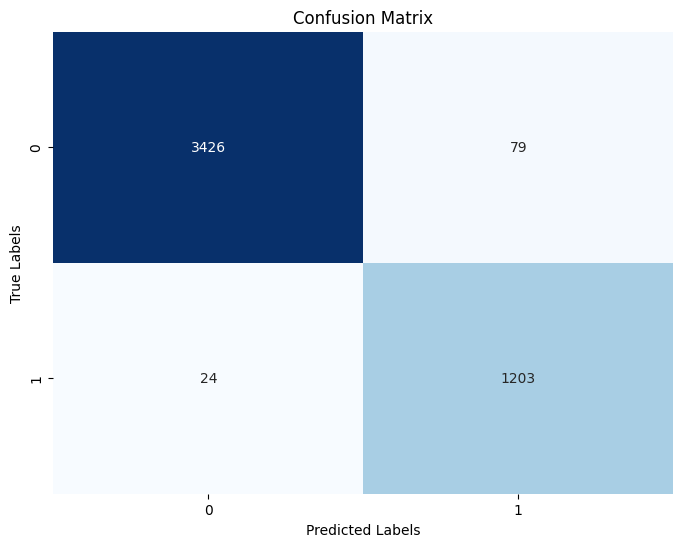

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3505
           1       0.94      0.98      0.96      1227

    accuracy                           0.98      4732
   macro avg       0.97      0.98      0.97      4732
weighted avg       0.98      0.98      0.98      4732



In [40]:
true_labels = []
predicted_labels = []

# Iterate over the test_loader to get predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model.predict_on_batch(inputs)
        preds = np.argmax(outputs, axis=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels)
print( classification_rep)

# Define Model without pretrained

In [45]:
base_model_not_pretrained = timm.create_model('tf_efficientnetv2_b2',pretrained= False)

summary(base_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 16, 112, 112]           4,608
          Identity-6         [-1, 16, 112, 112]               0
              SiLU-7         [-1, 16, 112, 112]               0
    BatchNormAct2d-8         [-1, 16, 112, 112]              32
         ConvBnAct-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           2,304
         Identity-11         [-1, 16, 112, 112]               0
             SiLU-12         [-1, 16, 112, 112]               0
   BatchNormAct2d-13         [-1, 16, 112, 112]              32
         Identity-14         [-1, 16, 1

In [47]:
# !mkdir drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP

optimizer = torch.optim.Adam(base_model_not_pretrained.parameters(), lr=0.001)
# pytorch_network = torch.nn.Linear(model.classifier.in_features, 2)

model_not_pretrained = poutyne.Model(base_model_not_pretrained, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model_not_pretrained.to(device)


filepath = 'drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP/Efficientnetv2_b2_NP.h5'
csv_logger_path = 'drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP/log.tsv'


# define callbacks for saving best epoch and logging the results.
callbacks = [
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        filepath,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(csv_logger_path, separator='\t'),

    CustomCallback('Efficientnetv2_b2_NP', model_not_pretrained)
]


# Use the fit_generator function to train the model
history = model_not_pretrained.fit_generator(train_loader, val_loader, epochs=4, callbacks = callbacks)

Epoch: 1/4 Train steps: 506 Val steps: 57 3m29.77s loss: 0.559550 acc: 71.440924 val_loss: 0.485351 val_acc: 76.209005
Epoch 1: val_acc improved from -inf to 76.20901, saving file to drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP/Efficientnetv2_b2_NP.h5
 Save model after one epoch
Epoch: 2/4 Train steps: 506 Val steps: 57 3m17.24s loss: 0.481894 acc: 77.191032 val_loss: 0.450922 val_acc: 79.210673
Epoch 2: val_acc improved from 76.20901 to 79.21067, saving file to drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP/Efficientnetv2_b2_NP.h5
Epoch: 3/4 Train steps: 506 Val steps: 57 3m10.63s loss: 0.442432 acc: 79.618306 val_loss: 0.418629 val_acc: 81.045025
Epoch 3: val_acc improved from 79.21067 to 81.04503, saving file to drive/MyDrive/cats_vs_dogs_task/Efficientnetv2_b2_NP/Efficientnetv2_b2_NP.h5
Epoch: 4/4 Train steps: 506 Val steps: 57 3m10.10s loss: 0.406196 acc: 82.323513 val_loss: 0.392278 val_acc: 83.324069
Epoch 4: val_acc improved from 81.04503 to 83.32407, saving file 

In [48]:
test_loss, test_acc = model_not_pretrained.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Test steps: 148 28.10s test_loss: 0.334769 test_acc: 86.073542                                
Test:
	Loss: 0.33476930156362733
	Accuracy: 86.07354184277261


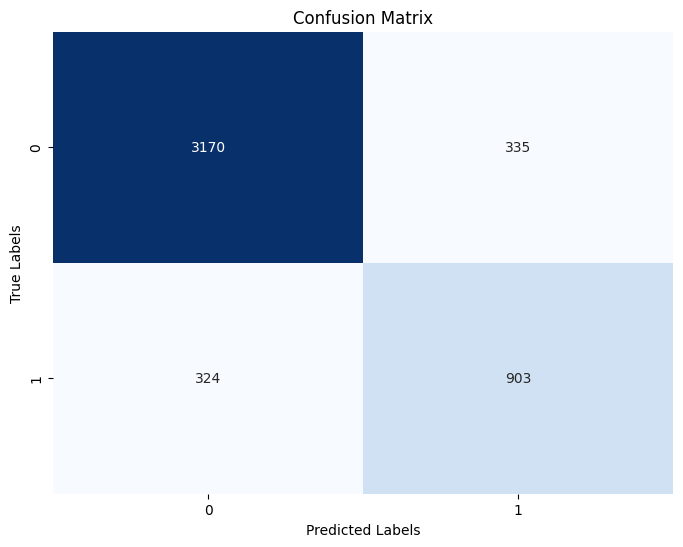

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3505
           1       0.73      0.74      0.73      1227

    accuracy                           0.86      4732
   macro avg       0.82      0.82      0.82      4732
weighted avg       0.86      0.86      0.86      4732



In [49]:
true_labels = []
predicted_labels = []

# Iterate over the test_loader to get predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model_not_pretrained.predict_on_batch(inputs)
        preds = np.argmax(outputs, axis=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels)
print( classification_rep)

In [ ]:
!gsutil ls gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/**

# Model Training for Dog vs. Cat Classification using PyTorch

## Introduction:
This documentation outlines the process of training an EfficientNetV2 model for a Dog vs. Cat classification task using PyTorch and Poutyne. The task involves classifying images as either dogs or cats. Data transformations, augmentation, model creation, and training processes are described in detail.

## Data Transformation and Augmentation:

1. **train_transform:** A series of transformations including random horizontal and vertical flips, random rotation (up to 15 degrees), resizing, converting to a PyTorch tensor, and normalization using ImageNet statistics.
2. **test_transform:** A series of transformations including resizing, converting to a PyTorch tensor, and normalization using ImageNet statistics.

## Dataset Creation and Loading:

1. Train and validation datasets are created using ImageFolder and Subset.
2. CustomCreateDataset class is used to apply the train_transform on the dataset.
3. DataLoader is used to load train and validation data in batches with shuffling.

## Base Model Initialization:

1. EfficientNetV2 model with the "tf_efficientnetv2_b2" architecture is initialized and loaded with pre-trained weights.
2. EfficientNetV2 model with the "tf_efficientnetv2_b2" architecture is initialized and loaded with random weights.
3. Summary of the model architecture is printed.

## Custom Callback:

1. A custom SaveModel callback is defined to save the model after the first epoch.
2. The saved model is also uploaded to Google Cloud Storage.
3. We use W&B (Weights & Biases) for experiment tracking.

## Poutyne Callbacks and Training:

1. The poutyne framework is used for training.
2. EarlyStopping, ModelCheckpoint, and WandbLogger callbacks are defined.
3. An EfficientNetV2 model is created using the poutyne.Model class.
4. The model is trained using the fit_generator function, and training history is stored.

## Result:

| Model                          | Accuracy |
|--------------------------------|----------|
| EfficientNetV2B2(Pretrained)                | 0.98     |
| EfficientNetV2B2(Without Pretrained)              | 0.86     |

# Conclusion:

This documentation showcases the complete process of training an EfficientNetV2 model for Dog vs. Cat classification using PyTorch and Poutyne. It provides insights into data transformation, model architecture, training callbacks, and W&B integration. The utilization of Poutyne and W&B enhances the efficiency and effectiveness of the training process, ultimately leading to a well-trained model for the given classification task.